# EDA notebook

Import

In [4]:
import pydicom
import numpy as np
import pandas as pd
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import glob


Metadata are given in the "train.csv" file, that is where the we have can find wether the patient has cancer or not along with other pieces of information.  
Information about the view and laterality is given and could be useful when training our model.


In [5]:
train_csv = pd.read_csv("data/train.csv")
train_csv[:5]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [6]:
print("The number of images is ",len(train_csv))
print("The number of patient is ",train_csv.patient_id.nunique())

The number of images is  54706
The number of patient is  11913


Let's take a look at different features distribution, starting from the cancer rate

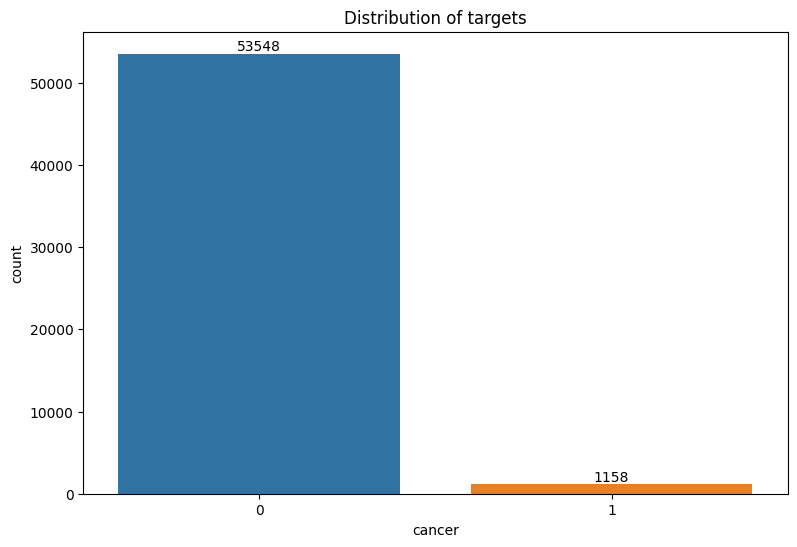

In [8]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_csv, x='cancer')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Distribution of targets');

But what does it mean when looking at the number of patient having a cancer ?

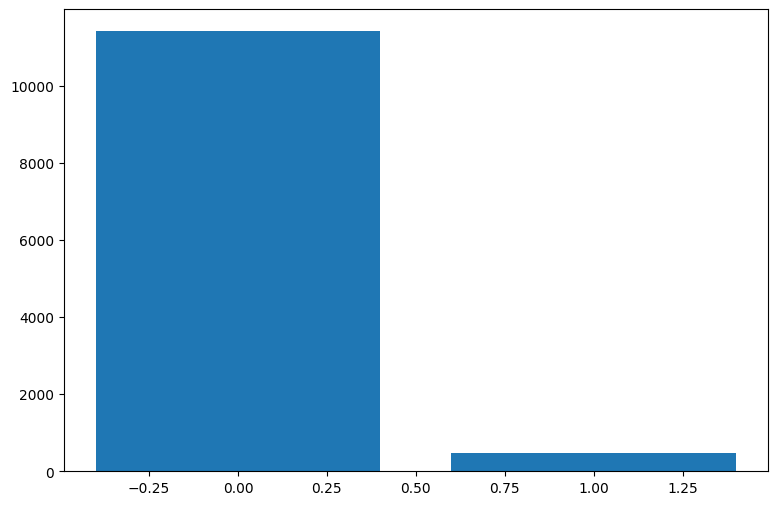

In [69]:
patient_cancer = train_csv.groupby('patient_id')['cancer'].max()
type(patient_cancer)
np_cancer = patient_cancer.values.sum()
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = plt.bar([0,1],[train_csv.patient_id.nunique() - np_cancer, np_cancer])
plt.title("Distribution of target among patients")

### DICOM image format overview

A DICOM file consists of a header and image data sets packed into a single file. The information within the header is organized as a constant and standardized series of tags. By extracting data from these tags one can access important information regarding the patient demographics, study parameters, etc.

In [ ]:
pydicom.dcmread("data/train_images/10006/1459541791.dcm")

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0020, 000e) Series Instance

In [ ]:
# source: https://www.kaggle.com/code/allunia/rsna-csf-cervical-spine-fracture-eda/notebook
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit."""
    data = dcm_ds.pixel_array
    if dcm_ds.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    return data * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept

In [ ]:
def show_images_for_patient(patient_id):
    patient_dir = os.path.join('data/train_images', str(patient_id))
    num_images = len(glob.glob(f"{patient_dir}/*"))
    print(f"Number of images for patient: {num_images}")
    fig, axs = plt.subplots(2, 2, figsize=(24,15))
    axs = axs.flatten()
    for i, img_path in enumerate(list(Path(patient_dir).iterdir())):
        ds = pydicom.dcmread(img_path)
        axs[i].imshow(rescale_img_to_hu(ds), cmap="bone")

Number of images for patient: 4


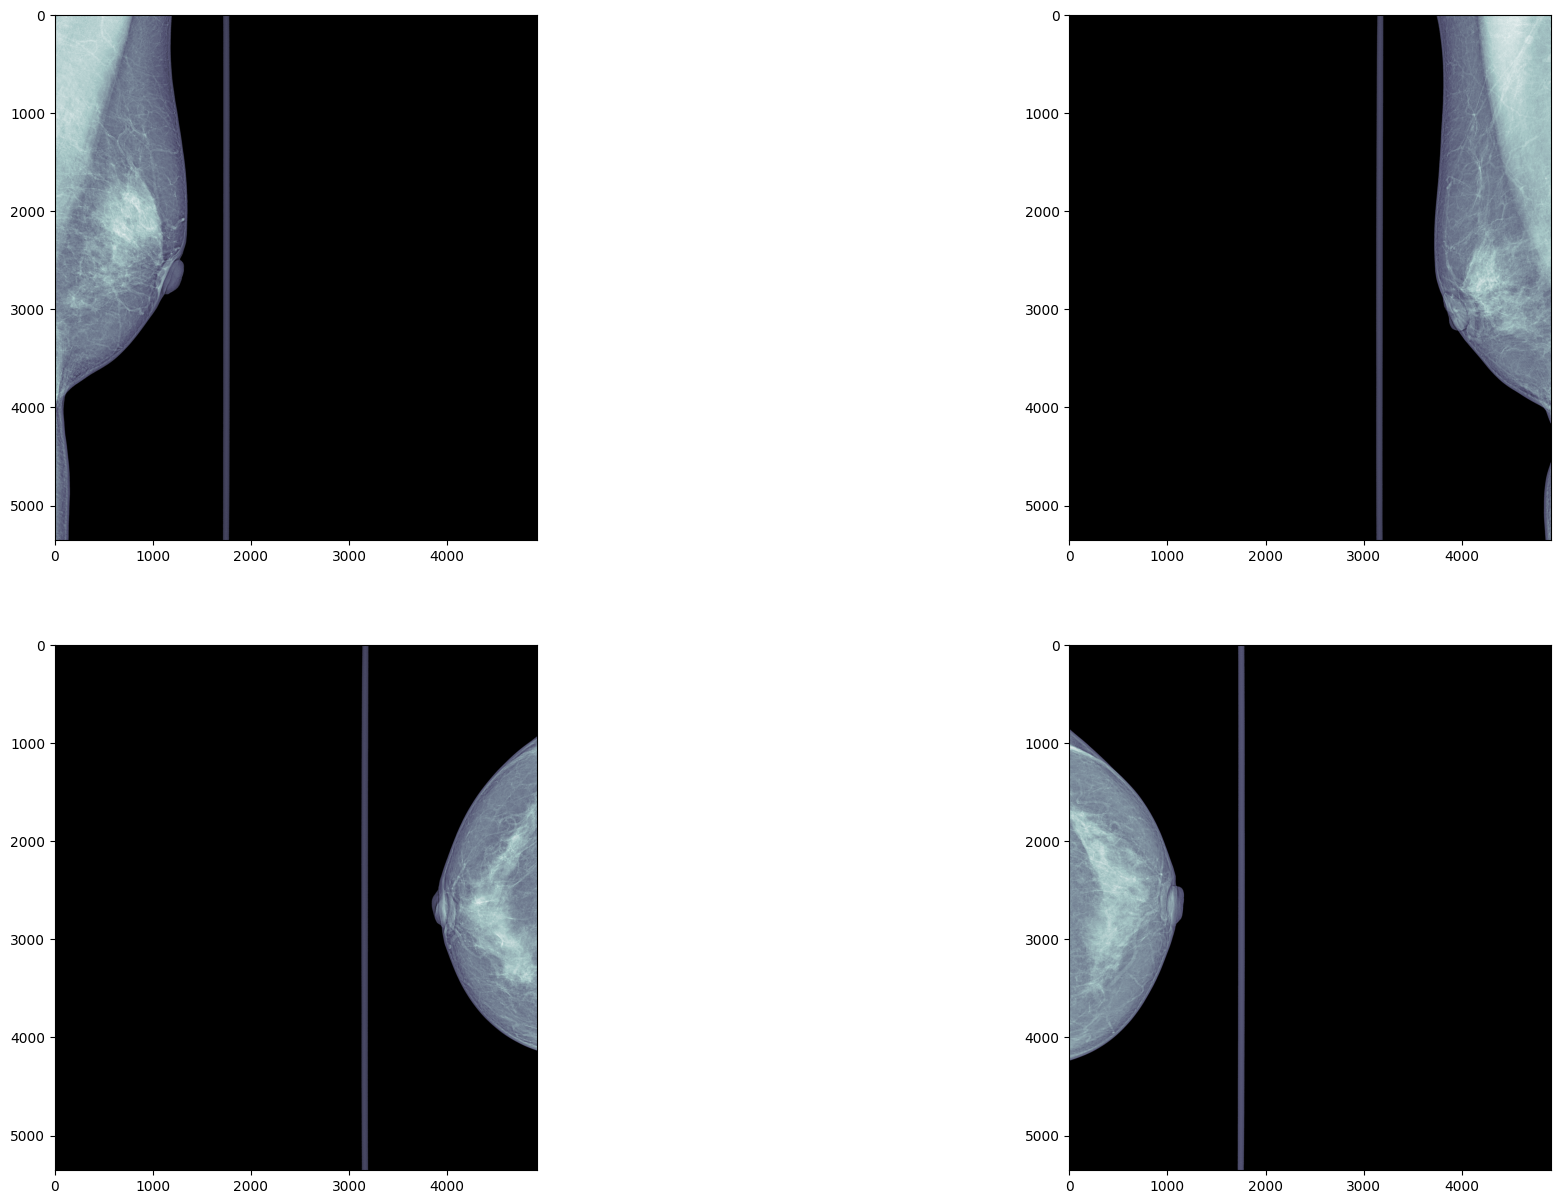

In [ ]:
show_images_for_patient(10006)

We can see that most of the image is black and thus not important.  
The size of the image is huge too.  
As we do not have access to unlimited computation power, we'll need to resize in a smart way the data we have. 